In [23]:
import subprocess
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

path = "C:/Users/Vincent/Documents/Project Portfolio/Global_retailer_dataset/"
database = path + 'database.sqlite'

In [24]:
conn = sqlite3.connect(database)
c = conn.cursor()

tables_to_create = ['Customers', 'Exchange_Rates', 'Products', 'Sales', 'Stores', 'Data_Dictionary']

for table in tables_to_create:
    # Drop the table if it exists
    csv_file = path + f"{table}.csv"
    df = pd.read_csv(csv_file, encoding='latin1')
    try:
        c.execute(f"DROP TABLE IF EXISTS {table}")
        df.to_sql(f"{table}", conn, if_exists='replace', index=False)
        conn.commit()
    except sqlite3.OperationalError as e:
        print(f"Error: {e}")
        conn.rollback()
        

# Verify the table creation by listing all tables in the database
tables = pd.read_sql("SELECT * FROM sqlite_master WHERE type='table';", conn)
print(tables)



    type             name         tbl_name  rootpage  \
0  table        Customers        Customers         2   
1  table   Exchange_Rates   Exchange_Rates         5   
2  table         Products         Products         7   
3  table            Sales            Sales         3   
4  table           Stores           Stores        13   
5  table  Data_Dictionary  Data_Dictionary        14   

                                                 sql  
0  CREATE TABLE "Customers" (\n"CustomerKey" INTE...  
1  CREATE TABLE "Exchange_Rates" (\n"Date" TEXT,\...  
2  CREATE TABLE "Products" (\n"ProductKey" INTEGE...  
3  CREATE TABLE "Sales" (\n"Order Number" INTEGER...  
4  CREATE TABLE "Stores" (\n"StoreKey" INTEGER,\n...  
5  CREATE TABLE "Data_Dictionary" (\n"Table" TEXT...  


In [25]:
# Convert column "Unit Price USD" to Float and remove '$'
c.execute("ALTER TABLE Products ADD COLUMN Unit_Price FLOAT")
c.execute('UPDATE Products SET Unit_Price = SUBSTR("Unit Price USD", 2)')
c.execute('ALTER TABLE Products DROP COLUMN "Unit Price USD"')
conn.commit()

In [26]:
# Convert column "Unit Cost USD" to Float and remove '$'
c.execute("ALTER TABLE Products ADD COLUMN Unit_Cost FLOAT")
c.execute('UPDATE Products SET Unit_Cost = SUBSTR("Unit Cost USD", 2)')
c.execute('ALTER TABLE Products DROP COLUMN "Unit Cost USD"')
conn.commit()

In [27]:
# Checking null values in Products Table

pd.read_sql('''
SELECT *
FROM Products
WHERE
    ProductKey IS NULL OR
    "Product Name" IS NULL OR
    Brand IS NULL OR
    Color IS NULL OR
    SubcategoryKey IS NULL OR
    CategoryKey IS NULL OR
    Category IS NULL OR
    Unit_Price IS NULL OR
    Unit_Cost IS NULL;''', conn)

,ProductKey,Product Name,Brand,Color,SubcategoryKey,Subcategory,CategoryKey,Category,Unit_Price,Unit_Cost


In [28]:
# Checking duplicate rows in Products Table

pd.read_sql('''
SELECT
    productkey,
    "product name",
    brand,
    color,
    subcategorykey,
    subcategory,
    categorykey,
    category,
    unit_price,
    unit_cost,
    COUNT(*) AS Count
FROM Products
GROUP BY
    productkey,
    "product name",
    brand,
    color,
    subcategorykey,
    subcategory,
    categorykey,
    category,
    unit_price,
    unit_cost
HAVING COUNT(*) > 1;''', conn)

,ProductKey,Product Name,Brand,Color,SubcategoryKey,Subcategory,CategoryKey,Category,Unit_Price,Unit_Cost,Count


In [29]:
# Clean Customers Table

# Convert Birthday data type to Date

c.execute('ALTER TABLE Customers ADD COLUMN Birthdate DATE')
c.execute('''
UPDATE Customers
SET Birthdate = (
    CASE
            WHEN LENGTH(Birthday) = 8 THEN SUBSTR(Birthday, 5) || '-0' || SUBSTR(Birthday, 1, 1) || '-0' || SUBSTR(Birthday, 3, 1)
            WHEN LENGTH(Birthday) = 9 THEN 
                CASE
                    WHEN SUBSTR(Birthday, 2, 1) = '/' THEN SUBSTR(Birthday, 6) || '-0' || SUBSTR(Birthday, 1, 1) || '-' || SUBSTR(Birthday, 3, 2)
                    ELSE SUBSTR(Birthday, 6) || '-' || SUBSTR(Birthday, 1, 2) || '-0' || SUBSTR(Birthday, 4, 1)
                END
            WHEN LENGTH(Birthday) = 10 THEN SUBSTR(Birthday, 7) || '-' || SUBSTR(Birthday, 1, 2) || '-' || SUBSTR(Birthday, 4, 2)
        END)''')
c.execute('ALTER TABLE Customers DROP COLUMN Birthday')
conn.commit()

In [30]:
# Checking Null Values in Customers Table

pd.read_sql('''
SELECT *
FROM Customers
WHERE CustomerKey IS NULL OR
    Gender IS NULL OR
    Name IS NULL OR
    City IS NULL OR
    'State Code' IS NULL OR
    State IS NULL OR
    'Zip Code' IS NULL OR
    Country IS NULL OR
    Continent IS NULL OR
    Birthdate IS NULL;''', conn)

,CustomerKey,Gender,Name,City,State Code,State,Zip Code,Country,Continent,Birthdate


In [31]:
# Checking Duplicate Rows in Customers Table

pd.read_sql('''
SELECT 
    customerkey,
    gender,
    name,
    city,
    "state code",
    state,
    "zip code",
    country,
    continent,
    birthdate,
    COUNT(*) AS Count
FROM Customers
GROUP BY
    customerkey,
    gender,
    name,
    city,
    "state code",
    state,
    "zip code",
    country,
    continent,
    birthdate
HAVING COUNT(*) > 1;''', conn)

,CustomerKey,Gender,Name,City,State Code,State,Zip Code,Country,Continent,Birthdate,Count


In [32]:
# Convert Order Date data type to Date in Sales Table

c.execute('ALTER TABLE Sales ADD COLUMN Order_Date DATE')
c.execute('''
UPDATE Sales
SET Order_Date = (
    CASE
            WHEN LENGTH("Order Date") = 8 THEN SUBSTR("Order Date", 5) || '-0' || SUBSTR("Order Date", 1, 1) || '-0' || SUBSTR("Order Date", 3, 1)
            WHEN LENGTH("Order Date") = 9 THEN 
                CASE
                    WHEN SUBSTR("Order Date", 2, 1) = '/' THEN SUBSTR("Order Date", 6) || '-0' || SUBSTR("Order Date", 1, 1) || '-' || SUBSTR("Order Date", 3, 2)
                    ELSE SUBSTR("Order Date", 6) || '-' || SUBSTR("Order Date", 1, 2) || '-0' || SUBSTR("Order Date", 4, 1)
                END
            WHEN LENGTH("Order Date") = 10 THEN SUBSTR("Order Date", 7) || '-' || SUBSTR("Order Date", 1, 2) || '-' || SUBSTR("Order Date", 4, 2)
        END)''')
c.execute('ALTER TABLE Sales DROP COLUMN "Order Date"')
conn.commit()

In [33]:
# Convert Delivery Date data type to Date in Sales Table

c.execute('ALTER TABLE Sales ADD COLUMN Delivery_Date DATE')
c.execute('''
UPDATE Sales
SET Delivery_Date = (
    CASE
            WHEN LENGTH("Delivery Date") = 8 THEN SUBSTR("Delivery Date", 5) || '-0' || SUBSTR("Delivery Date", 1, 1) || '-0' || SUBSTR("Delivery Date", 3, 1)
            WHEN LENGTH("Delivery Date") = 9 THEN 
                CASE
                    WHEN SUBSTR("Delivery Date", 2, 1) = '/' THEN SUBSTR("Delivery Date", 6) || '-0' || SUBSTR("Delivery Date", 1, 1) || '-' || SUBSTR("Delivery Date", 3, 2)
                    ELSE SUBSTR("Delivery Date", 6) || '-' || SUBSTR("Delivery Date", 1, 2) || '-0' || SUBSTR("Delivery Date", 4, 1)
                END
            WHEN LENGTH("Delivery Date") = 10 THEN SUBSTR("Delivery Date", 7) || '-' || SUBSTR("Delivery Date", 1, 2) || '-' || SUBSTR("Delivery Date", 4, 2)
        END)''')
c.execute('ALTER TABLE Sales DROP COLUMN "Delivery Date"')
conn.commit()

In [34]:
# Checking Null Values in Sales Table

pd.read_sql('''
SELECT *
FROM Sales
WHERE
    ("order number" IS NULL OR
    "line item" IS NULL OR
    order_date IS NULL OR
    delivery_date IS NULL OR
    customerkey IS NULL OR
    storekey IS NULL OR 
    productkey IS NULL OR
    quantity IS NULL OR
    "currency code" IS NULL) AND
    storekey != 0;''', conn)

# Based on the results, delivery date is null if it was bought on store or storekey != 0 while storekey = 10 is an online
# store where delivery of product has to be made.

,Order Number,Line Item,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code,Order_Date,Delivery_Date
0,366000,1,265598,10,1304,1,CAD,2016-01-01,None
1,366004,1,1107461,38,163,6,GBP,2016-01-01,None
2,366004,2,1107461,38,1529,2,GBP,2016-01-01,None
3,366005,1,844003,33,421,4,EUR,2016-01-01,None
4,366007,1,2035771,43,1617,1,USD,2016-01-01,None
...,...,...,...,...,...,...,...,...,...
49714,2243025,1,1909290,49,1128,2,USD,2021-02-20,None
49715,2243025,2,1909290,49,2511,2,USD,2021-02-20,None
49716,2243026,1,1737466,49,58,6,USD,2021-02-20,None
49717,2243028,1,1728060,66,1584,3,USD,2021-02-20,None


In [35]:
# Checking Duplciate rows in Sales Table
pd.read_sql('''
SELECT
    "order number",
    "line item",
    order_date,
    delivery_date,
    customerkey,
    storekey,
    productkey,
    quantity,
    "currency code",
    COUNT(*) AS Count
FROM Sales
GROUP BY 
    "order number",
    "line item",
    order_date,
    delivery_date,
    customerkey,
    storekey,
    productkey,
    quantity,
    "currency code"
HAVING COUNT(*) > 1;''', conn)

,Order Number,Line Item,Order_Date,Delivery_Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code,Count


In [36]:
# Convert Open Date data type to Date

c.execute('ALTER TABLE Stores ADD COLUMN Open_Date DATE')
c.execute('''
UPDATE Stores
SET Open_Date = (
    CASE
            WHEN LENGTH("Open Date") = 8 THEN SUBSTR("Open Date", 5) || '-0' || SUBSTR("Open Date", 1, 1) || '-0' || SUBSTR("Open Date", 3, 1)
            WHEN LENGTH("Open Date") = 9 THEN 
                CASE
                    WHEN SUBSTR("Open Date", 2, 1) = '/' THEN SUBSTR("Open Date", 6) || '-0' || SUBSTR("Open Date", 1, 1) || '-' || SUBSTR("Open Date", 3, 2)
                    ELSE SUBSTR("Open Date", 6) || '-' || SUBSTR("Open Date", 1, 2) || '-0' || SUBSTR("Open Date", 4, 1)
                END
            WHEN LENGTH("Open Date") = 10 THEN SUBSTR("Open Date", 7) || '-' || SUBSTR("Open Date", 1, 2) || '-' || SUBSTR("Open Date", 4, 2)
        END)''')
c.execute('ALTER TABLE Stores DROP COLUMN "Open Date"')
conn.commit()

In [37]:
# Checking Duplicate rows on Stores Table

pd.read_sql('''
SELECT
    storekey,
    country,
    state,
    "square meters",
    open_date,
    COUNT(*) AS Count
FROM Stores
GROUP BY
    storekey,
    country,
    state,
    "square meters",
    open_date 
HAVING Count(*) > 1;''', conn)

,StoreKey,Country,State,Square Meters,Open_Date,Count


In [38]:
# Update Data Dictionary for Column names that was changed
# Update Birthday to Birthdate
c.execute('''
UPDATE Data_Dictionary
SET Field = 'Birthdate'
WHERE Field = "Birthday"''')

# Update Unit Cost USD to Unit_Cost
# Update Unit Price USD to Unit_Price
c.execute('''
UPDATE Data_Dictionary
SET Field = 'Unit_Cost'
WHERE Field = "Unit Cost USD"''')
c.execute('''
UPDATE Data_Dictionary
SET Field = 'Unit_Price'
WHERE Field = "Unit Price USD"''')

# Update Open Date to Open_Date
c.execute('''
UPDATE Data_Dictionary
SET Field = 'Open_Date'
WHERE Field = "Open Date"''')

conn.commit()


In [39]:
# Query 10 Most Profitable Products
top10_products_df = pd.read_sql('''
SELECT
    p.ProductKey,
    p."Product Name",
    SUM(s.Quantity) AS quantity_sold,
    SUM(s.Quantity * p.Unit_Price) AS total_sales,
    SUM(s.Quantity * p.Unit_Cost) AS total_cost_goods,
    SUM(s.Quantity * p.Unit_Price) - SUM(s.Quantity * p.Unit_Cost) AS total_profit
FROM Sales as s
JOIN Products as p
ON s.ProductKey = p.ProductKey
WHERE strftime('%Y', order_date) = (SELECT MAX(strftime('%Y', order_date)) FROM Sales)
GROUP BY p.ProductKey, p."Product Name"
ORDER BY total_profit DESC
LIMIT 10;''', conn)

top10_products_df

,ProductKey,Product Name,quantity_sold,total_sales,total_cost_goods,total_profit
0,416,Adventure Works Desktop PC2.33 XD233 Silver,28,27132.0,8989.40,18142.60
1,455,WWI Desktop PC2.33 X2330 White,20,18380.0,6089.60,12290.40
2,1443,The Phone Company Touch Screen Phone 1600 TFT-...,28,16492.0,5464.20,11027.80
3,438,WWI Desktop PC2.33 X2330 Silver,14,12866.0,4262.72,8603.28
4,428,Adventure Works Desktop PC2.33 XD233 Brown,10,9690.0,3210.50,6479.50
5,423,Adventure Works Desktop PC2.30 MD230 Black,19,11381.0,5233.74,6147.26
6,433,Adventure Works Desktop PC2.33 XD233 White,9,8721.0,2889.45,5831.55
7,542,Proseware Projector 720p DLP56 Black,10,9990.0,4594.00,5396.00
8,1425,The Phone Company Touch Screen Phone 1600 TFT-...,15,7935.0,2629.05,5305.95
9,444,WWI Desktop PC2.33 X2330 Black,8,7352.0,2435.84,4916.16


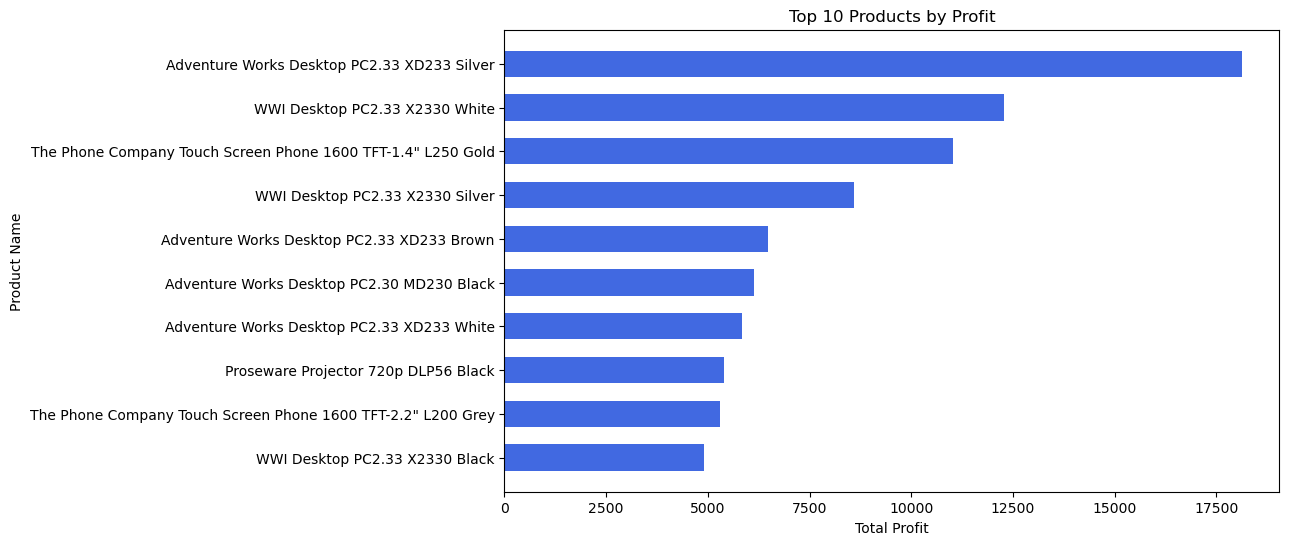

In [65]:
# Plotting top 10 products profit
plt.figure(figsize=(10, 6))
bar_width = 0.6
plt.barh(top10_products_df['Product Name'], top10_products_df['total_profit'], color='royalblue', height = bar_width)
plt.xlabel('Total Profit')
plt.ylabel('Product Name')
plt.title('Top 10 Products by Profit')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest profit on top
plt.show()

In [54]:
# Top 10 Most Profitable Stores and where it is located
top10_stores_df = pd.read_sql('''
SELECT
    stores.storekey,
    stores.country,
    stores.state,
    SUM(sales.quantity * products.unit_price) AS total_sales,
    SUM(sales.quantity * products.unit_cost) AS total_cost_goods,
    SUM(sales.quantity * products.unit_price) - SUM(sales.quantity * products.unit_cost) AS total_profit
FROM Stores
JOIN Sales 
ON stores.storekey = sales.storekey
JOIN Products
ON sales.productkey = products.productkey
GROUP BY stores.storekey, stores.country, stores.state
ORDER BY total_profit DESC
LIMIT 10;''', conn)

top10_stores_df

,StoreKey,Country,State,total_sales,total_cost_goods,total_profit
0,0,Online,Online,8941131.31,4656427.37,4284703.94
1,45,United States,Connecticut,1080364.07,551160.78,529203.29
2,54,United States,Nebraska,1074717.82,560326.32,514391.50
3,65,United States,West Virginia,1019252.80,507338.28,511914.52
4,9,Canada,Northwest Territories,1063240.26,555037.19,508203.07
5,50,United States,Kansas,1058325.43,565545.96,492779.47
6,55,United States,Nevada,1056804.46,576741.46,480063.00
7,51,United States,Maine,937169.36,467588.36,469581.00
8,8,Canada,Newfoundland and Labrador,960051.82,491137.98,468913.84
9,61,United States,South Carolina,996910.36,531154.25,465756.11


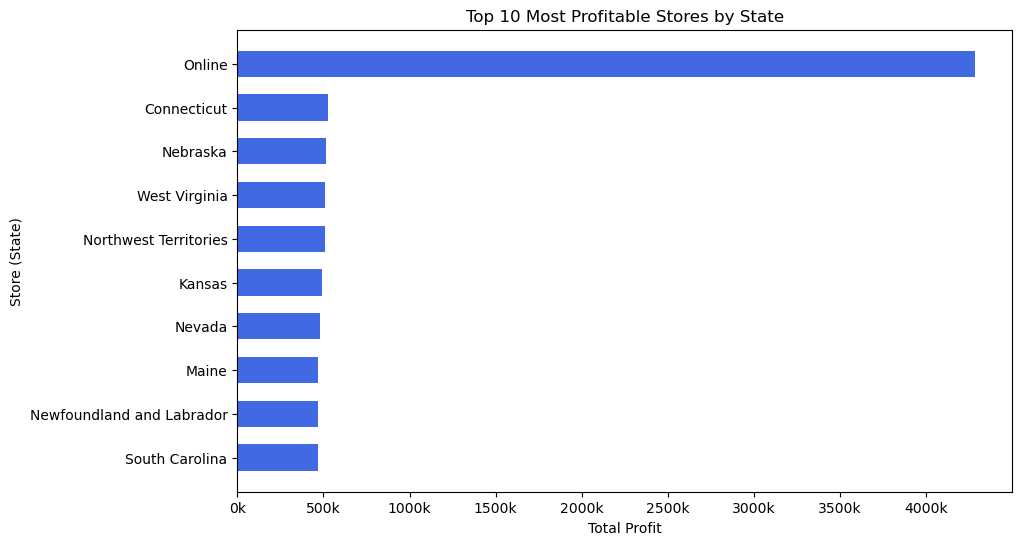

In [67]:
# Plotting top 10 most profitable stores location by state
plt.figure(figsize=(10, 6))
bar_width = 0.6
plt.barh(top10_stores_df['State'], top10_stores_df['total_profit'], color='royalblue', height = bar_width)
plt.xlabel('Total Profit')
plt.ylabel('Store (State)')
plt.title('Top 10 Most Profitable Stores by State')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
plt.show()

In [75]:
pd.read_sql('''
SELECT storekey, COUNT(*)
FROM Stores
GROUP BY storekey''', conn)

,StoreKey,COUNT(*)
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
62,62,1
63,63,1
64,64,1
65,65,1


In [79]:
# Query sales per Country and number of stores
pd.read_sql('''
SELECT
    stores.country,
    stores.storekey,
    SUM(sales.quantity * products.unit_price) AS total_sales,
    SUM(sales.quantity * products.unit_cost) AS total_cost_goods,
    SUM(sales.quantity * products.unit_price) - SUM(sales.quantity * products.unit_cost) AS total_profit
FROM Stores
JOIN Sales 
ON stores.storekey = sales.storekey
JOIN Products
ON sales.productkey = products.productkey
GROUP BY stores.country, stores.storekey
ORDER BY stores.country;''', conn)

,Country,StoreKey,total_sales,total_cost_goods,total_profit
0,Australia,1,174144.13,96378.19,77765.94
1,Australia,2,9380.01,5663.38,3716.63
2,Australia,4,274023.17,176103.37,97919.80
3,Australia,5,600869.97,329595.52,271274.45
4,Australia,6,434569.23,220231.02,214338.21
5,Canada,8,960051.82,491137.98,468913.84
6,Canada,9,1063240.26,555037.19,508203.07
7,Canada,10,834562.61,432649.72,401912.89
8,France,12,152756.24,76006.51,76749.73
9,France,13,122832.20,61967.47,60864.73


## Aggregate Table for Dashboard Generation

In [115]:
# Get Total Sales, Total Profit, Previous Sales per Year per Country

total_sales_df = pd.read_sql('''
WITH total_sales AS (SELECT
    strftime('%Y-%m', order_date) AS Year_month,
    stores.country,
    SUM(sales.quantity * products.unit_price) AS total_sales,
    SUM(sales.quantity * products.unit_price) - SUM(sales.quantity * products.unit_cost) AS total_profit
FROM Sales 
JOIN Products
ON sales.productkey = products.productkey
JOIN Stores
ON stores.storekey = sales.storekey
GROUP BY strftime('%Y-%m', order_date), stores.country
ORDER BY strftime('%Y', order_date), strftime('%m', order_date)
),
previous_sales AS (SELECT
    year_month,
    country,
    total_sales,
    CASE 
        WHEN LAG(total_sales,1) OVER (PARTITION BY country ORDER BY SUBSTR(year_month, 1, 4)) IS NULL THEN 0
        ELSE LAG(total_sales,1) OVER (PARTITION BY country ORDER BY SUBSTR(year_month, 1, 4)) END AS prev_sales,
    total_profit,
    CASE 
        WHEN LAG(total_profit,1) OVER (PARTITION BY country ORDER BY SUBSTR(year_month, 1, 4)) IS NULL THEN 0
        ELSE LAG(total_profit,1) OVER (PARTITION BY country ORDER BY SUBSTR(year_month, 1, 4)) END AS prev_profit
FROM total_sales)

SELECT
    year_month,
    country,
    total_sales,
    prev_sales,
    total_profit,
    prev_profit
FROM previous_sales;''', conn)

In [104]:
# Most Profitable and Quantites Sold Product Category per year

product_sales_df = pd.read_sql('''
SELECT
    strftime('%Y-%m', order_date) AS Year_month,
    p."Product Name",
    p.Category,
    p.Subcategory,
    SUM(s.Quantity) AS quantity_sold,
    SUM(s.Quantity * p.Unit_Price) AS total_sales,
    SUM(s.Quantity * p.Unit_Cost) AS total_cost_of_goods,
    SUM(s.Quantity * p.Unit_Price) - SUM(s.Quantity * p.Unit_Cost) AS total_profit
FROM Sales as s
JOIN Products as p
ON s.ProductKey = p.ProductKey
GROUP BY strftime('%Y-%m', order_date), p."Product Name"
ORDER BY strftime('%Y', order_date), strftime('%m', order_date);''', conn)

In [105]:
# New Customers per Year

new_customers_df = pd.read_sql('''
WITH first_buy AS (
SELECT
    c.customerkey,
    MIN(s.order_date) AS first_buy_date
FROM Customers as c
JOIN Sales as s
ON c.customerkey = s.customerkey
GROUP BY c.customerkey)

SELECT
    strftime('%Y-%m', first_buy_date) AS Year_month,
    COUNT(CustomerKey) AS New_customers
FROM first_buy
GROUP BY strftime('%Y-%m', first_buy_date);''', conn)

In [106]:
# Get Customer Age Distribution

age_df = pd.read_sql('''
WITH age_table AS (SELECT
    s.customerkey,
    s.order_date,
    c.birthdate,
    CAST(strftime('%Y', s.order_date) AS INTEGER) - CAST(strftime('%Y', c.birthdate) AS INTEGER) AS Age
FROM Sales as s
JOIN Customers as c
ON s.customerkey = c.customerkey),

age_groups AS (
SELECT
    CASE
        WHEN Age BETWEEN 0 AND 17 THEN '0-17'
        WHEN Age BETWEEN 18 AND 24 THEN '18-24'
        WHEN Age BETWEEN 25 AND 34 THEN '25-34'
        WHEN Age BETWEEN 35 AND 44 THEN '35-44'
        WHEN Age BETWEEN 45 AND 54 THEN '45-54'
        WHEN Age BETWEEN 55 AND 64 THEN '55-64'
        ELSE '65+'
    END AS age_group,
    customerkey
FROM age_table)

SELECT
    age_group,
    COUNT(customerkey) AS num_customers
FROM age_groups
GROUP BY age_group
ORDER BY CAST(SUBSTR(age_group, 1) AS INTEGER)''', conn)

## Export dataframes into csv for dashboard creation

In [116]:
import os

path = "C:/Users/Vincent/Documents/Project Portfolio/Global_retailer_dataset/tables"

export_list = ['total_sales_df', 'product_sales_df', 'new_customers_df', 'age_df']

for tables in export_list:
    df = globals()[tables]
    df.to_csv(os.path.join(path, f"{tables}.csv"), index=False)
print("Exported successfully")

Exported successfully
